In [4]:
from __future__ import print_function, division
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

## IBM Model 1: Generative Process
Step 1: Pick an alignmet $a$ with probability  p(a|e,m) = $\frac{1}{(l+1)^m}$

Step 2: pick the French words with probability

p(f|a,e,m) = $\prod^m_{j=1} t(f_j | e_aj )$



P(f,a|e, m ) = p(a|e,m) $\times$ p(f|a,e,m)


In [5]:
#alignment prob per sentence
#pseudo code

def alignprobIBM1(english, french):
    m = len(french.split())
    l = len(english.split())
    
    return 1/((l +1)^m)


#todo build a dictionary that takes all the words and the frequencies 
# or only the allignments

In [6]:
englishfileloc = 'training/hansards.36.2.e'
frenchfileloc = 'training/hansards.36.2.f'

#transition dictionary
transdict = {}    



In [7]:
english_sentences = []
french_sentences = []
with open(englishfileloc, 'r', encoding='utf8') as engf, open(frenchfileloc, 'r', encoding='utf8') as fref:
    for line in engf:
        english_sentences.append(line.split())
    for line in fref:
        french_sentences.append(line.split())
assert len(english_sentences) == len(french_sentences), 'data mismatch'

In [8]:
def EM_IBM1(english, french, max_steps=None):
    translate_dict = {}
    for _ in range(max_steps):
        change = False
        
        counts = defaultdict(float)
        co_counts = defaultdict(float)
        for e_s,f_s in tqdm(zip(english, french)):
            for i, f in enumerate(f_s):
                sum_of_probs = sum([translate_dict.get((e, f), 0.1) for e in e_s]) # the 0.1 is our initialization
                for j, e in enumerate(e_s):
                    single_prob = translate_dict.get((e,f), 0.1)
                    co_counts[(e, f)] += single_prob / sum_of_probs
                    counts[e] += single_prob / sum_of_probs
        for e, f in co_counts:
            new_value = co_counts[(e, f)] / counts[e]
            if abs(translate_dict.get((e, f), 1000) - new_value) > 1e-5:
                change = True
            translate_dict[(e,f)] = new_value
        if not change:
            break
    return translate_dict

pickle_filename = 'IBM1_translate_dict.pkl'
#translate_dict = EM_IBM1(english_sentences, french_sentences, 8)
#with open(pickle_filename, 'wb') as pf:
#    pickle.dump(translate_dict, pf)
with open(pickle_filename, 'rb') as pf:
    translate_dict = pickle.load(pf)

In [11]:
def print_translation_probs(english_word, transdict):
    results = []
    for key in translate_dict:
        if key[0] == english_word:
            results.append((translate_dict[key], key))
    results.sort(reverse=True)
    for r in results[:20]:
        print(r)
        
print_translation_probs('crap', translate_dict)

(0.11220320080154243, ('crap', 'mettons'))
(0.11159110668878097, ('crap', 'côté'))
(0.07240405390476944, ('crap', 'esprit'))
(0.06504376787093226, ('crap', 'emballage'))
(0.06504376787091752, ('crap', 'comparer'))
(0.06504376253729913, ('crap', 'résume'))
(0.06484416293538516, ('crap', 'présentées'))
(0.06445548593515063, ('crap', 'rendre'))
(0.06435224002038081, ('crap', 'étudier'))
(0.06404490694074151, ('crap', 'foutaises'))
(0.06271266051797754, ('crap', 'compte'))
(0.059143150564169786, ('crap', 'sous'))
(0.053324053496580606, ('crap', 'parti'))
(0.0372623512341336, ('crap', 'alors'))
(0.0317117268364449, ('crap', 'nouvel'))
(0.0048860421832367445, ('crap', 'mêmes'))
(0.0006986856337113329, ('crap', 'de'))
(0.000623779506365362, ('crap', 'se'))
(0.00040136797117198194, ('crap', 'on'))
(6.62508849820368e-05, ('crap', 'a'))


In [20]:
def Naacl(englishfile, frenchfile, translate_dict, fname=None):
    sentence_no = 1
    file = open(fname, 'w')
    for english_sent, french_sent in tqdm(zip(open(englishfile), open(frenchfile))):
        english_words = english_sent.split()
        french_words = french_sent.split()
        for index, eword in enumerate(english_words):
            position_L1 = index + 1
            position_L2 = 0
            prior = 0
            for indexf, fword in enumerate(french_words):
                key = (eword, fword)
                prob = translate_dict.get(key,0)
                if(prob > prior):
                    prior = prob
                    position_L2 = indexf + 1
            file.write(str(sentence_no)  + " " + str(position_L1) + " " + str(position_L2) + " S\n")
        sentence_no += 1
                 
englishval = 'validation/dev.e'
frenchval = 'validation/dev.f'
fname = 'naacltest.txt'

Naacl(englishval, frenchval, translate_dict, fname)

37it [00:00, 1803.73it/s]


In [36]:
def EM_IBM2(english, french, initial_translation_estimate, max_steps=3):
    translate_dict = initial_translation_estimate
    jump_dict = {}
    for _ in range(max_steps):
        counts = defaultdict(int)
        co_counts = defaultdict(int)
        jump_counts = defaultdict(int)
        pos_counts = 0
        for e_s,f_s in tqdm(zip(english, french)):
            m = len(f_s)
            l = len(e_s)
            for i, f in enumerate(f_s):
                sum_of_probs = 0
                for j, e in enumerate(e_s):
                    jump_prob = jump_dict.get(get_jump(j,i,l,m), 0.1)
                    translate_prob = translate_dict.get((e,f), 0.1)
                    sum_of_probs += jump_prob * translate_prob
                for j, e in enumerate(e_s):
                    jump_prob = jump_dict.get(get_jump(j,i,l,m), 0.1)
                    translate_prob = translate_dict.get((e,f), 0.1)
                    prob = jump_prob * translate_prob / sum_of_probs
                    co_counts[(e,f)] += prob
                    counts[e] += prob
                    jump_counts[get_jump(j,i,l,m)] += prob
                    pos_counts += prob
        for e,f in co_counts:
            translate_dict[(e,f)] = co_counts[(e, f)] / counts[e]
        for jump in jump_counts:
            jump_dict[jump] = jump_counts[jump] / pos_counts
    return translate_dict, jump_dict

def get_jump(eng_pos, fre_pos, eng_len, fre_len):
    equivalent_pos = round(fre_pos * eng_len / fre_len)
    return eng_pos - equivalent_pos

ibm2_transdict, ibm2_jumpdict = EM_IBM2(english_sentences, french_sentences, translate_dict, 2)

231164it [09:59, 385.30it/s]
231164it [10:04, 382.66it/s]


(0.39914268816162973, ('agriculture', 'le'))
(0.35063301660348195, ('agriculture', 0))
(0.2635239689034394, ('agriculture', 'agriculture'))
(0.13411341063197404, ('agriculture', 'AGRICULTURE'))
(0.10186451580458386, ('agriculture', 'Agriculture'))
(0.06069426094185534, ('agriculture', 'agricole'))
(0.05270296426635559, ('agriculture', 4))
(0.03642755018486908, ('agriculture', 9))
(0.03327971407095108, ('agriculture', 10))
(0.02979131973866131, ('agriculture', 12))
(0.02928878564339327, ('agriculture', 8))
(0.029161281626303673, ('agriculture', 14))
(0.028378090093545666, ('agriculture', 6))
(0.028152195870811685, ('agriculture', 15))
(0.02737106957594277, ('agriculture', 7))
(0.027258608846119147, ('agriculture', 3))
(0.027198123926976358, ('agriculture', 13))
(0.024983388193978284, ('agriculture', 11))
(0.021357162828538778, ('agriculture', 5))
(0.021010054284597367, ('agriculture', 'secteur'))


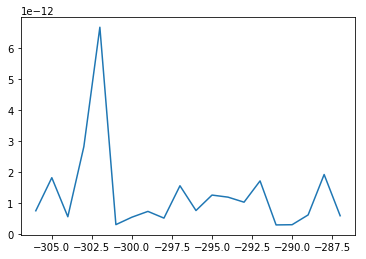

1.00000000004


In [37]:
print_translation_probs('agriculture', ibm2_transdict)
jumps = np.array(sorted(ibm2_jumpdict.items()))
plt.plot(jumps[65:85,0], jumps[65:85,1])
plt.show()
print(sum(jumps[:,1]))